Este notebook contem o fluxo de tentantivas com as solucoes de diferentes instancias

No seguinte bloco de Codigo, vamos definir todas as classes que serao utilizadas na pesquisa, dessa maneira, quando quisermos reutiliza-las durante o estudo, nao precisaremos reescrever codigo.

In [21]:
# Importando bibliotecas necessárias 
import pandas as pd
import re
import math
from amplpy import AMPL, DataFrame
import matplotlib.pyplot as plt  # Importar matplotlib para plotar
import numpy as np
from datetime import datetime

class TTPInstance:
    def __init__(self, arquivo):
        self.arquivo = arquivo
        self.matriz_distancias= None
        self.total_cidades = None
        self.n_item = None
        self.capacity = None
        self.min_speed = None
        self.max_speed = None
        self.rent_ratio = None
        self.df_cidades = None
        self._ler_instancia()

    def _ler_linha_específica(self, numero_linha):
        with open(self.arquivo, 'r') as file:
            linhas = file.readlines()
            if 1 <= numero_linha <= len(linhas):
                return linhas[numero_linha - 1]

    def _ler_arquivo(self):
        with open(self.arquivo, 'r') as file:
            linhas = file.readlines()
        return linhas

    def _extrair_numero(self, linha):
        matches = re.findall(r'\d+\.\d+|\d+', linha)
        if matches:
            return float(matches[-1])
        else:
            raise ValueError(f"Não foi possível extrair um número da linha: {linha}")

    def _ler_instancia(self):
        # Extraindo parâmetros gerais
        self.total_cidades = int(self._extrair_numero(self._ler_linha_específica(3)))
        self.n_item = int(self._extrair_numero(self._ler_linha_específica(4)))
        self.capacity = int(self._extrair_numero(self._ler_linha_específica(5)))
        self.min_speed = self._extrair_numero(self._ler_linha_específica(6))
        self.max_speed = self._extrair_numero(self._ler_linha_específica(7))
        self.rent_ratio = self._extrair_numero(self._ler_linha_específica(8))

        # Lendo as coordenadas das cidades e itens
        linhas = self._ler_arquivo()

        # Encontrar o índice das seções
        inicio_cidades = None
        inicio_itens = None

        for idx, linha in enumerate(linhas):
            linha_strip = linha.strip()
            if linha_strip.startswith('NODE_COORD_SECTION'):
                inicio_cidades = idx + 1  # A próxima linha é o início dos dados das cidades
            elif linha_strip.startswith('ITEMS SECTION'):
                inicio_itens = idx + 1  # A próxima linha é o início dos dados dos itens
                break  # Após encontrar ITEMS SECTION, não precisamos continuar

        if inicio_cidades is None or inicio_itens is None:
            raise ValueError("Não foi possível encontrar as seções NODE_COORD_SECTION ou ITEMS SECTION no arquivo.")

        cidades_dados = linhas[inicio_cidades:inicio_itens - 1]
        itens_dados = linhas[inicio_itens:]

        # Processando dados das cidades
        cidades = []
        for linha in cidades_dados:
            partes = linha.strip().split()
            if len(partes) >= 3:
                index = int(partes[0])
                x = float(partes[1])
                y = float(partes[2])
                cidades.append({'index': index, 'x': x, 'y': y})

        self.df_cidades = pd.DataFrame(cidades)
        self.df_cidades.set_index('index', inplace=True)

        # Processando dados dos itens
        itens = []
        for linha in itens_dados:
            partes = linha.strip().split()
            if len(partes) >= 4:
                index = int(partes[0])
                profit = float(partes[1])
                weight = float(partes[2])
                cidade = int(partes[3])
                itens.append({'index': index, 'profit': profit, 'weight': weight, 'cidade': cidade})

        self.df_itens = pd.DataFrame(itens)
        self.df_itens.set_index('index', inplace=True)

        # Calculando a matriz de distâncias
        self._calcular_matriz_distancias()

    def _calcular_matriz_distancias(self):
        def calcular_distancia(cidade1, cidade2):
            return math.hypot(cidade2['x'] - cidade1['x'], cidade2['y'] - cidade1['y'])

        self.matriz_distancias = {}
        indices = self.df_cidades.index.tolist()
        for i in indices:
            for j in indices:
                if i != j:
                    dist = calcular_distancia(self.df_cidades.loc[i], self.df_cidades.loc[j])
                    self.matriz_distancias[i, j] = dist

class RoutePlotter:
    def __init__(self, instancia, rota):
        self.instancia = instancia
        self.rota = rota

    def plotar_rota(self, titulo='Rota do Viajante'):
        df_cidades = self.instancia.df_cidades

        # Extrair as coordenadas das cidades
        x_coords = df_cidades['x']
        y_coords = df_cidades['y']

        # Criar um DataFrame com as coordenadas das cidades
        cidades = df_cidades.copy()
        cidades['index'] = cidades.index

        # Criar figura e eixos
        plt.figure(figsize=(10, 8))
        plt.title(titulo)
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')

        # Plotar as cidades
        plt.scatter(cidades['x'], cidades['y'], c='blue')

        # Adicionar labels às cidades
        for idx, row in cidades.iterrows():
            plt.text(row['x'] + 0.5, row['y'] + 0.5, str(idx), fontsize=9)

        # Construir a lista de pontos da rota
        rota_pontos = [self.rota[0][0]] + [j for (_, j) in self.rota]

        # Adicionar a cidade inicial para fechar o ciclo
        if rota_pontos[0] != rota_pontos[-1]:
            rota_pontos.append(rota_pontos[0])

        # Obter as coordenadas da rota
        rota_coords_x = [df_cidades.loc[city]['x'] for city in rota_pontos]
        rota_coords_y = [df_cidades.loc[city]['y'] for city in rota_pontos]

        # Plotar a rota
        plt.plot(rota_coords_x, rota_coords_y, c='red', linestyle='-', linewidth=2, marker='o')

        # Mostrar o gráfico
        plt.grid(True)
        plt.show()

class KPThenTSPSolver:
    def __init__(self, instancia):
        self.instancia = instancia
        self.ampl = AMPL()
        self.ampl.setOption('solver', 'gurobi')

    def solve(self):
        self._resolver_kp()
        self._resolver_tsp()
        self._calcular_ttp()

    def _resolver_kp(self):
        ampl = AMPL()
        ampl.setOption('solver', 'gurobi')

        modelo_kp = '''
        param m integer;
        param W;

        param Profit{1..m};
        param Weight{1..m};

        var y{1..m} binary;

        maximize TotalProfit:
            sum {k in 1..m} Profit[k] * y[k];

        subject to KnapsackConstraint:
            sum {k in 1..m} Weight[k] * y[k] <= W;
        '''
        ampl.eval(modelo_kp)

        instancia = self.instancia

        # Ajuste dos índices
        profit_dict = instancia.df_itens['profit'].to_dict()
        weight_dict = instancia.df_itens['weight'].to_dict()
        min_index = min(instancia.df_itens.index)
        if min_index == 0:
            profit_dict = {k+1: v for k, v in profit_dict.items()}
            weight_dict = {k+1: v for k, v in weight_dict.items()}
            item_indices = [k+1 for k in instancia.df_itens.index]
        else:
            item_indices = instancia.df_itens.index.tolist()

        ampl.param['m'] = instancia.n_item
        ampl.param['W'] = instancia.capacity
        ampl.param['Profit'] = profit_dict
        ampl.param['Weight'] = weight_dict

        ampl.solve()

        y_sol = ampl.getVariable('y').getValues()
        y_values = y_sol.toDict()

        if min_index == 0:
            self.itens_selecionados = [k for k in instancia.df_itens.index if y_values.get(k+1, 0) > 0.5]
        else:
            self.itens_selecionados = [k for k in instancia.df_itens.index if y_values.get(k, 0) > 0.5]

    def _resolver_tsp(self):
        ampl = self.ampl

        cidades_tsp = self.instancia.df_cidades.index.tolist()

        modelo_tsp = '''
        set NODES;

        param n integer;
        param Distance{NODES, NODES};

        var x{NODES, NODES} binary;
        var u{NODES} >= 0;

        minimize TotalTime:
            sum {i in NODES, j in NODES : i != j} (Distance[i,j] / vc) * x[i,j];

        subject to OneOut{i in NODES}:
            sum {j in NODES : j != i} x[i,j] == 1;

        subject to OneIn{j in NODES}:
            sum {i in NODES : i != j} x[i,j] == 1;

        subject to SubtourElimination{i in NODES, j in NODES :
            i != j and i != 1 and j != 1}:
            u[i] - u[j] + n * x[i,j] <= n - 1;

        var u{NODES} >= 0;
        '''
        ampl.eval(modelo_tsp)

        # Parâmetro de velocidade constante
        ampl.param['vc'] = self.instancia.max_speed  # Supondo que vc é vmax

        ampl.set['NODES'] = cidades_tsp
        ampl.param['n'] = len(cidades_tsp)
        ampl.param['Distance'] = self.instancia.matriz_distancias

        ampl.solve()

        x_sol = ampl.getVariable('x').getValues()
        x_values = x_sol.toDict()

        # Reconstruindo a rota
        rota = []
        current_city = 1  # Cidade inicial
        visited = set()
        while True:
            visited.add(current_city)
            next_cities = [j for j in cidades_tsp if x_values.get((current_city, j), 0) > 0.5 and j not in visited]
            if not next_cities:
                break
            next_city = next_cities[0]
            rota.append((current_city, next_city))
            current_city = next_city

        self.rota = rota

    def _calcular_ttp(self):
        # Calcular lucro total considerando a rota e itens selecionados
        instancia = self.instancia

        # Peso acumulado
        peso_acumulado = 0
        tempo_total = 0
        lucro_itens = 0

        for (i, j) in self.rota:
            # Adiciona itens coletados na cidade i
            itens_na_cidade = [k for k in self.itens_selecionados if instancia.df_itens.loc[k]['cidade'] == i]
            peso_cidade = sum(instancia.df_itens.loc[k]['weight'] for k in itens_na_cidade)
            lucro_cidade = sum(instancia.df_itens.loc[k]['profit'] for k in itens_na_cidade)
            peso_acumulado += peso_cidade
            lucro_itens += lucro_cidade

            # Calcula a velocidade atual
            velocidade = instancia.max_speed - ((instancia.max_speed - instancia.min_speed) * (peso_acumulado / instancia.capacity))

            # Tempo para percorrer de i para j
            distancia = instancia.matriz_distancias[i, j]
            tempo = distancia / velocidade
            tempo_total += tempo

        custo_aluguel = instancia.rent_ratio * tempo_total

        self.lucro_total = lucro_itens - custo_aluguel

    def resultados(self):
        print("===== KP -> TSP =====")
        print("Rota Ótima:")
        for (i, j) in self.rota:
            print(f"Cidade {i} -> Cidade {j}")

        print("\nItens Selecionados:")
        for k in self.itens_selecionados:
            item = self.instancia.df_itens.loc[k]
            print(f"Item {k}: Lucro = {item['profit']}, Peso = {item['weight']}, Cidade = {item['cidade']}")

        print(f"\nLucro Total: {self.lucro_total}")


class TSPThenKPSolver:
    def __init__(self, instancia):
        self.instancia = instancia
        self.ampl = AMPL()
        self.ampl.setOption('solver', 'gurobi')

    def solve(self):
        self._resolver_tsp()
        self._resolver_kp()
        self._calcular_ttp()

    def _resolver_tsp(self):
        ampl = self.ampl

        modelo_tsp = '''
        set NODES;

        param n integer;
        param Distance{NODES, NODES};
        param vc;

        var x{NODES, NODES} binary;
        var u{NODES} >= 0;

        minimize TotalTime:
            sum {i in NODES, j in NODES : i != j} (Distance[i,j] / vc) * x[i,j];

        subject to OneOut{i in NODES}:
            sum {j in NODES : j != i} x[i,j] == 1;

        subject to OneIn{j in NODES}:
            sum {i in NODES : i != j} x[i,j] == 1;

        subject to SubtourElimination{i in NODES, j in NODES :
            i != j and i != 1 and j != 1}:
            u[i] - u[j] + n * x[i,j] <= n - 1;

        var u{NODES} >= 0;
        '''
        ampl.eval(modelo_tsp)

        ampl.set['NODES'] = self.instancia.df_cidades.index.tolist()
        ampl.param['n'] = self.instancia.total_cidades
        ampl.param['Distance'] = self.instancia.matriz_distancias
        ampl.param['vc'] = self.instancia.max_speed  # Supondo que vc é vmax

        ampl.solve()

        x_sol = ampl.getVariable('x').getValues()
        x_values = x_sol.toDict()

        # Reconstruindo a rota
        rota = []
        current_city = 1  # Supondo que a cidade inicial é a de índice 1
        visited = set()
        while True:
            visited.add(current_city)
            next_cities = [j for j in self.instancia.df_cidades.index if x_values.get((current_city, j), 0) > 0.5 and j not in visited]
            if not next_cities:
                break
            next_city = next_cities[0]
            rota.append((current_city, next_city))
            current_city = next_city

        self.rota = rota

    def _resolver_kp(self):
        ampl = AMPL()
        ampl.setOption('solver', 'gurobi')

        modelo_kp = '''
        param m integer;
        param W;

        param Profit{1..m};
        param Weight{1..m};

        var y{1..m} binary;

        maximize TotalProfit:
            sum {k in 1..m} Profit[k] * y[k];

        subject to KnapsackConstraint:
            sum {k in 1..m} Weight[k] * y[k] <= W;
        '''
        ampl.eval(modelo_kp)

        instancia = self.instancia

        # Ajuste dos índices
        profit_dict = instancia.df_itens['profit'].to_dict()
        weight_dict = instancia.df_itens['weight'].to_dict()
        min_index = min(instancia.df_itens.index)
        if min_index == 0:
            profit_dict = {k+1: v for k, v in profit_dict.items()}
            weight_dict = {k+1: v for k, v in weight_dict.items()}
            item_indices = [k+1 for k in instancia.df_itens.index]
        else:
            item_indices = instancia.df_itens.index.tolist()

        ampl.param['m'] = instancia.n_item
        ampl.param['W'] = instancia.capacity
        ampl.param['Profit'] = profit_dict
        ampl.param['Weight'] = weight_dict

        ampl.solve()

        y_sol = ampl.getVariable('y').getValues()
        y_values = y_sol.toDict()

        if min_index == 0:
            self.itens_selecionados = [k for k in instancia.df_itens.index if y_values.get(k+1, 0) > 0.5]
        else:
            self.itens_selecionados = [k for k in instancia.df_itens.index if y_values.get(k, 0) > 0.5]

    def _calcular_ttp(self):
        # Calcular lucro total considerando a rota e itens selecionados
        instancia = self.instancia

        # Peso acumulado
        peso_acumulado = 0
        tempo_total = 0
        lucro_itens = 0

        for (i, j) in self.rota:
            # Adiciona itens coletados na cidade i
            itens_na_cidade = [k for k in self.itens_selecionados if instancia.df_itens.loc[k]['cidade'] == i]
            peso_cidade = sum(instancia.df_itens.loc[k]['weight'] for k in itens_na_cidade)
            lucro_cidade = sum(instancia.df_itens.loc[k]['profit'] for k in itens_na_cidade)
            peso_acumulado += peso_cidade
            lucro_itens += lucro_cidade

            # Calcula a velocidade atual
            velocidade = instancia.max_speed - ((instancia.max_speed - instancia.min_speed) * (peso_acumulado / instancia.capacity))

            # Tempo para percorrer de i para j
            distancia = instancia.matriz_distancias[i, j]
            velocidade = max(velocidade, instancia.min_speed)  # Garantir que a velocidade não seja menor que vmin
            tempo = distancia / velocidade
            tempo_total += tempo

        custo_aluguel = instancia.rent_ratio * tempo_total

        self.lucro_total = lucro_itens - custo_aluguel

    def resultados(self):
        print("===== TSP -> KP =====")
        print("Rota Ótima:")
        for (i, j) in self.rota:
            print(f"Cidade {i} -> Cidade {j}")

        print("\nItens Selecionados:")
        for k in self.itens_selecionados:
            item = self.instancia.df_itens.loc[k]
            print(f"Item {k}: Lucro = {item['profit']}, Peso = {item['weight']}, Cidade = {item['cidade']}")

        print(f"\nLucro Total: {self.lucro_total}")


class TTPIntegratedSolver:
    def __init__(self, instancia):
        self.instancia = instancia
        self.ampl = AMPL()
        self.ampl.setOption('solver', 'gurobi')
        self._definir_modelo()
        self._definir_dados()

    def _definir_modelo(self):
        modelo_ampl = '''
        set NODES;

        param n integer;
        param m integer;
        param W;  # Capacidade máxima da mochila
        param vmax;
        param vmin;
        param R;

        param Profit{ITEMS};
        param Weight{ITEMS};
        param AssignNode{ITEMS};

        param Distance{NODES, NODES};

        var x{NODES, NODES} binary;
        var y{ITEMS} binary;
        var u{NODES} >= 0;

        minimize TotalCost:
            sum {i in NODES, j in NODES : i != j} Distance[i,j] * x[i,j] / (vmax - (vmax - vmin) * (carry(i) / W))
            - sum {k in ITEMS} Profit[k] * y[k] + R * sum {i in NODES, j in NODES : i != j} Distance[i,j] * x[i,j] / (vmax - (vmax - vmin) * (carry(i) / W));

        subject to OneOut{i in NODES}:
            sum {j in NODES : j != i} x[i,j] == 1;

        subject to OneIn{j in NODES}:
            sum {i in NODES : i != j} x[i,j] == 1;

        subject to SubtourElimination{i in NODES, j in NODES : i != j and i != 1 and j != 1}:
            u[i] - u[j] + n * x[i,j] <= n - 1;

        subject to KnapsackConstraint:
            sum {k in ITEMS} Weight[k] * y[k] <= W;

        # Função para calcular o peso carregado na cidade i
        param carry {i in NODES} := sum {k in ITEMS : AssignNode[k] == i} Weight[k] * y[k];

        set ITEMS := 1..m;
        '''
        self.ampl.eval(modelo_ampl)

    def _definir_dados(self):
        ampl = self.ampl
        instancia = self.instancia

        ampl.set['NODES'] = instancia.df_cidades.index.tolist()
        ampl.param['n'] = instancia.total_cidades
        ampl.param['m'] = instancia.n_item
        ampl.param['W'] = instancia.capacity
        ampl.param['vmax'] = instancia.max_speed
        ampl.param['vmin'] = instancia.min_speed
        ampl.param['R'] = instancia.rent_ratio

        # Ajuste de índices se necessário
        profit_dict = instancia.df_itens['profit'].to_dict()
        weight_dict = instancia.df_itens['weight'].to_dict()
        assign_node_dict = instancia.df_itens['cidade'].to_dict()

        # Verificar se os índices começam em 0 ou 1
        min_index = min(instancia.df_itens.index)
        if min_index == 0:
            profit_dict = {k+1: v for k, v in profit_dict.items()}
            weight_dict = {k+1: v for k, v in weight_dict.items()}
            assign_node_dict = {k+1: v for k, v in assign_node_dict.items()}
            item_indices = [k+1 for k in instancia.df_itens.index]
        else:
            item_indices = instancia.df_itens.index.tolist()

        ampl.set['ITEMS'] = item_indices

        ampl.param['Profit'] = profit_dict
        ampl.param['Weight'] = weight_dict
        ampl.param['AssignNode'] = assign_node_dict

        # Ajustar a matriz de distâncias para usar índices coerentes
        distance_dict = {}
        for (i, j), dist in instancia.matriz_distancias.items():
            distance_dict[i, j] = dist

        ampl.param['Distance'] = distance_dict

    def solve(self):
        # Configurar opções adicionais se necessário
        ampl.setOption('relax_integrality', True)

        # Solução do modelo
        try:
            self.ampl.solve()
            self._extrair_resultados()
        except Exception as e:
            print("Erro ao resolver o modelo integrado:", e)
            self.rota = []
            self.itens_selecionados = []
            self.lucro_total = None

    def _extrair_resultados(self):
        ampl = self.ampl

        x_sol = ampl.getVariable('x').getValues()
        y_sol = ampl.getVariable('y').getValues()

        # Convertendo os valores de x e y para dicionários
        x_values = x_sol.toDict()
        y_values = y_sol.toDict()

        # Reconstruindo a rota
        rota = []
        current_city = 1  # Supondo que a cidade inicial é a de índice 1
        visited = set()
        while True:
            visited.add(current_city)
            # Obter as cidades adjacentes a current_city com x[current_city, j] > 0.5
            next_cities = [j for j in self.instancia.df_cidades.index if x_values.get((current_city, j), 0) > 0.5]
            if not next_cities or next_cities[0] in visited:
                break
            next_city = next_cities[0]
            rota.append((current_city, next_city))
            current_city = next_city

        self.rota = rota

        # Ajustar índices se necessário
        min_index = min(self.instancia.df_itens.index)
        if min_index == 0:
            itens_selecionados = [k for k in self.instancia.df_itens.index if y_values.get(k+1, 0) > 0.5]
        else:
            itens_selecionados = [k for k in self.instancia.df_itens.index if y_values.get(k, 0) > 0.5]
        self.itens_selecionados = itens_selecionados

        # Lucro total
        self.lucro_total = ampl.getObjective('TotalCost').value()

    def resultados(self):
        print("===== TTP Integrado =====")
        if not self.rota or not self.itens_selecionados or self.lucro_total is None:
            print("Não foi possível resolver o modelo integrado.")
            return

        print("Rota Ótima:")
        for (i, j) in self.rota:
            print(f"Cidade {i} -> Cidade {j}")

        print("\nItens Selecionados:")
        for k in self.itens_selecionados:
            item = self.instancia.df_itens.loc[k]
            print(f"Item {k}: Lucro = {item['profit']}, Peso = {item['weight']}, Cidade = {item['cidade']}")

        print(f"\nLucro Total: {self.lucro_total}")


In [24]:
# Executando nossa primeira Instancia
arquivo_instancia = 'data/eil51_n50_bounded-strongly-corr_01.txt'
instancia = TTPInstance(arquivo_instancia)

Solucao Resolvendo ps metodos exatos de forma separada, primeiro KP depois TSP sem alteracoes

inicio KPThenTSPSolver
Gurobi 11.0.3:Gurobi 11.0.3: optimal solution; objective 7124
2 simplex iterations
1 branching node
Gurobi 11.0.3:Gurobi 11.0.3: optimal solution; objective 428.8717564
51269 simplex iterations
1993 branching nodes
Finalizado KPThenTSPSolver
===== KP -> TSP =====
Rota Ótima:
Cidade 1 -> Cidade 32
Cidade 32 -> Cidade 11
Cidade 11 -> Cidade 38
Cidade 38 -> Cidade 5
Cidade 5 -> Cidade 37
Cidade 37 -> Cidade 17
Cidade 17 -> Cidade 4
Cidade 4 -> Cidade 18
Cidade 18 -> Cidade 47
Cidade 47 -> Cidade 12
Cidade 12 -> Cidade 46
Cidade 46 -> Cidade 51
Cidade 51 -> Cidade 27
Cidade 27 -> Cidade 6
Cidade 6 -> Cidade 48
Cidade 48 -> Cidade 23
Cidade 23 -> Cidade 7
Cidade 7 -> Cidade 43
Cidade 43 -> Cidade 24
Cidade 24 -> Cidade 14
Cidade 14 -> Cidade 25
Cidade 25 -> Cidade 13
Cidade 13 -> Cidade 41
Cidade 41 -> Cidade 40
Cidade 40 -> Cidade 19
Cidade 19 -> Cidade 42
Cidade 42 -> Cidade 44
Cidade 44 -> Cidade 15
Cidade 15 -> Cidade 45
Cidade 45 -> Cidade 33
Cidade 33 -> Cidade 

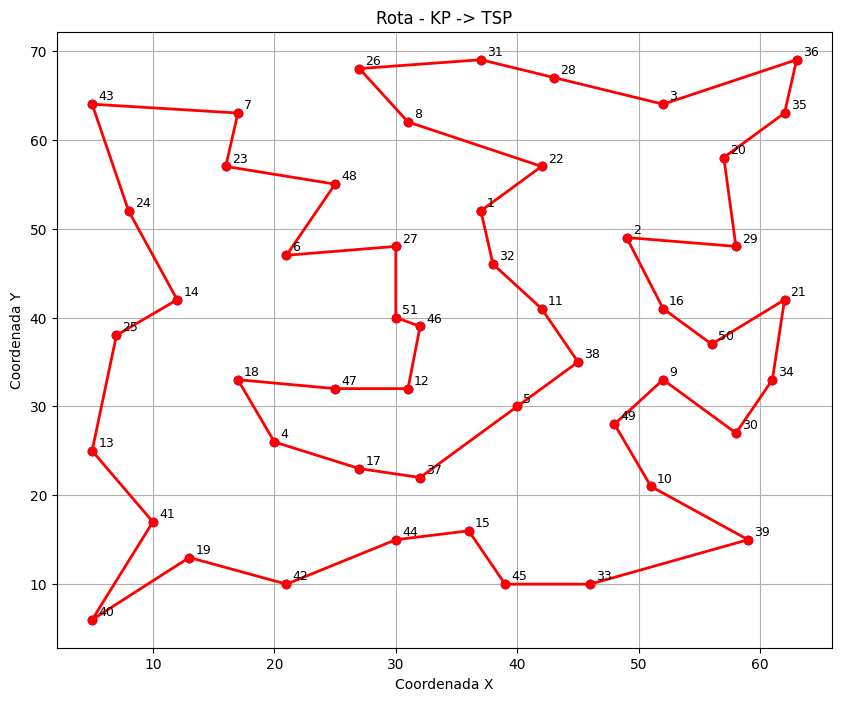

In [25]:

# Resolver primeiro o TSP, depois o KP
solver_kp_tsp = KPThenTSPSolver(instancia)
print("inicio KPThenTSPSolver")
solver_kp_tsp.solve()
print("Finalizado KPThenTSPSolver")
solver_kp_tsp.resultados()

plotter = RoutePlotter(instancia, solver_kp_tsp.rota)
plotter.plotar_rota(titulo='Rota - KP -> TSP')

Solucao resolvendo primeiro TSP depois KP

inicio TSPThenKPSolver
Gurobi 11.0.3:Gurobi 11.0.3: optimal solution; objective 428.8717564
51269 simplex iterations
1993 branching nodes
Gurobi 11.0.3:Gurobi 11.0.3: optimal solution; objective 7124
2 simplex iterations
1 branching node
Finalizado TSPThenKPSolver
===== TSP -> KP =====
Rota Ótima:
Cidade 1 -> Cidade 32
Cidade 32 -> Cidade 11
Cidade 11 -> Cidade 38
Cidade 38 -> Cidade 5
Cidade 5 -> Cidade 37
Cidade 37 -> Cidade 17
Cidade 17 -> Cidade 4
Cidade 4 -> Cidade 18
Cidade 18 -> Cidade 47
Cidade 47 -> Cidade 12
Cidade 12 -> Cidade 46
Cidade 46 -> Cidade 51
Cidade 51 -> Cidade 27
Cidade 27 -> Cidade 6
Cidade 6 -> Cidade 48
Cidade 48 -> Cidade 23
Cidade 23 -> Cidade 7
Cidade 7 -> Cidade 43
Cidade 43 -> Cidade 24
Cidade 24 -> Cidade 14
Cidade 14 -> Cidade 25
Cidade 25 -> Cidade 13
Cidade 13 -> Cidade 41
Cidade 41 -> Cidade 40
Cidade 40 -> Cidade 19
Cidade 19 -> Cidade 42
Cidade 42 -> Cidade 44
Cidade 44 -> Cidade 15
Cidade 15 -> Cidade 45
Cidade 45 -> Cidade 33
Cidade 33 -> Cidade 

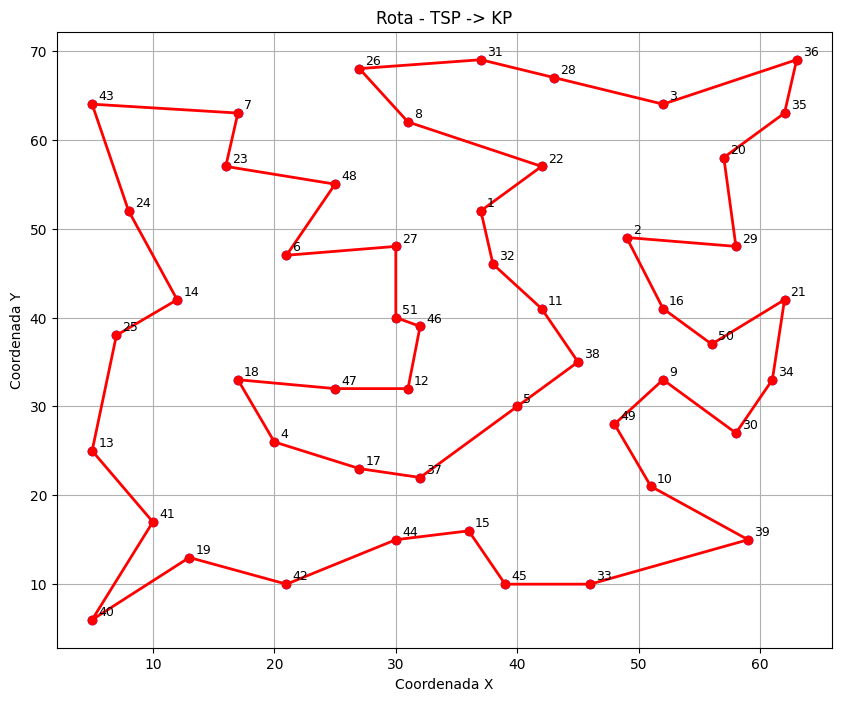

In [26]:
# Resolver primeiro o TSP, depois o KP
solver_tsp_kp = TSPThenKPSolver(instancia)
print("inicio TSPThenKPSolver")
solver_tsp_kp.solve()
print("Finalizado TSPThenKPSolver")
solver_tsp_kp.resultados()

plotter = RoutePlotter(instancia, solver_tsp_kp.rota)
plotter.plotar_rota(titulo='Rota - TSP -> KP')

Solucao Integrada, ainda nao consegui rodar por conta de nao linearizacao

In [ ]:
# Resolver o TTP integrado
solver_integrado = TTPIntegratedSolver(instancia)
print("inicio TSPThenKPSolver")
print("Data e Hora de Início:", datetime.now())
solver_integrado.solve()
print("Finalizado TSPThenKPSolver", datetime.now())
solver_integrado.resultados()

plotter = RoutePlotter(instancia, solver_integrado.rota)
plotter.plotar_rota(titulo='Rota - TSP -> KP')

Vamos comecar com as Heuristicas, dado que nao conseguimos linearizar o modelo

Resumo da proposta da Heuristica
1) Sabendo que a funcao objetivo do TTP pode ser simplificada como:

   MAX LUCRO   =  MAX(LUCRO KP) - MIN(CUSTO DE LOCACAO TOTAL TSP)

2) Podemos buscar identificar quais os efeitos das variaveis de forma parcial, para tentarmos buscar uma heuristica:

   LUCRO e diretatemnte proporcial as variaveis  <>  "Profit Item"
   LUCRO e inversamente proporcial as variaveis <> "Peso do Item" e "Distancia que o Item tera que percorrer ate o fim do percurso"

3) Tendo isso em mente, podemos ter o seguinte criterio:

   i) Quanto uma cidade possui itens com melhor custo beneficio que outras?
   ii) Podemos classificar os itens em:
        - Muito bom profit e mais Pesado;
        - Muito bom profit e medio Pesado;
        - Muito bom profit e menos Pesado;
        - Bom profit e Mais Pesado;
        - Bom profit e medio Pesado;
        - Bom profit e menos Pesado;
        - Baixo profit e Mais Pesado;
        - Baixo profit e medio Pesado;
        - Bom profit e menos Pesado;

        Para classificar, podemos utilizar a razao Profit/Peso, Profit e Peso.


Separar o cluster de Regioes com grande custo beneficio, para que sejam trilhadas rotas com base nessas subrotas com problemas de TPS divididos e depois consolidados


c:\Users\Diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

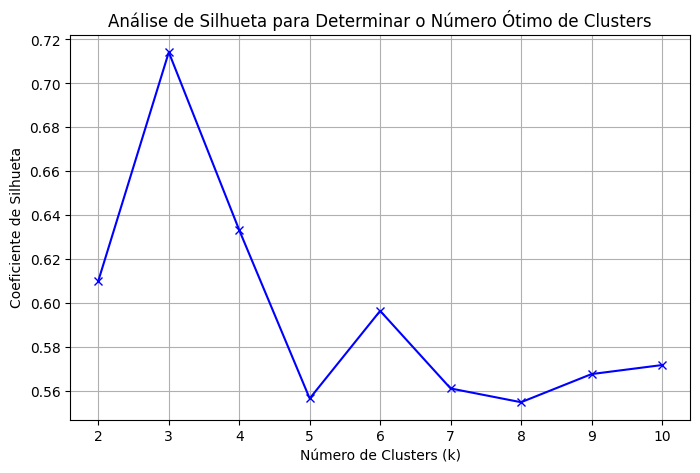

Número ótimo de clusters determinado: 3


c:\Users\Diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [37]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class TTPHeuristicSolver:
    def __init__(self, instancia):
        self.instancia = instancia
        self.itens_ordenados = None  # DataFrame com itens ordenados pela razão
        self.rota = None
        self.lucro_total = None
        self.df_itens = None  # DataFrame dos itens com categorias
        self.optimal_k = None  # Número ótimo de clusters

    def solve(self):
        self._calcular_razao()
        self._determinar_numero_otimo_clusters()
        self._classificar_itens()
        #self._plotar_classificacao()
        # Você pode adicionar mais etapas aqui para desenvolver a heurística completa

    def _calcular_razao(self):
        # Calcula a razão Lucro / Peso para cada item
        df_itens = self.instancia.df_itens.copy()
        df_itens['ratio'] = df_itens['profit'] / df_itens['weight']
        # Ordena os itens pela razão em ordem decrescente
        df_itens.sort_values(by='ratio', ascending=False, inplace=True)
        self.itens_ordenados = df_itens

    def _determinar_numero_otimo_clusters(self):
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        from sklearn.metrics import silhouette_score
        import matplotlib.pyplot as plt

        df_itens = self.instancia.df_itens.copy()
        df_itens['ratio'] = df_itens['profit'] / df_itens['weight']

        # Selecionar as características para clustering
        features = df_itens[['profit', 'weight', 'ratio']].values

        # Normalizar as características
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Intervalo de valores de k a serem testados
        k_values = range(2, 11)
        silhouette_scores = []

        # Calcular o coeficiente de silhueta para cada k
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(features_scaled)
            silhouette_avg = silhouette_score(features_scaled, labels)
            silhouette_scores.append(silhouette_avg)

        # Plotar o coeficiente de silhueta em função de k
        plt.figure(figsize=(8, 5))
        plt.plot(k_values, silhouette_scores, 'bx-')
        plt.xlabel('Número de Clusters (k)')
        plt.ylabel('Coeficiente de Silhueta')
        plt.title('Análise de Silhueta para Determinar o Número Ótimo de Clusters')
        plt.grid(True)
        plt.show()

        # Encontrar o k com o maior coeficiente de silhueta
        self.optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
        print(f"Número ótimo de clusters determinado: {self.optimal_k}")

    def _classificar_itens(self):
      from sklearn.cluster import KMeans
      from sklearn.preprocessing import StandardScaler
      from sklearn.decomposition import PCA

      df_itens = self.instancia.df_itens.copy()

      # Selecionar as características para clustering
      features = df_itens[['profit', 'weight']].values

      # Normalizar as características
      scaler = StandardScaler()
      features_scaled = scaler.fit_transform(features)

      # Aplicar PCA para reduzir a dimensionalidade
      pca = PCA(n_components=1)
      principal_components = pca.fit_transform(features_scaled)

      # Aplicar o K-Means com o número ótimo de clusters
      kmeans = KMeans(n_clusters=self.optimal_k, random_state=42)
      df_itens['cluster'] = kmeans.fit_predict(principal_components)

      # Armazenar o DataFrame atualizado
      self.df_itens = df_itens


# Criar e executar o solver heurístico
solver_heuristico = TTPHeuristicSolver(instancia)
solver_heuristico.solve()
